In [545]:
import numpy as np
import matplotlib.pyplot as plt
import pymc as pm
import pickle
from datetime import datetime as dt 

# Setup Environment

Given that at each timestep the user will observe a distance and speed of the vehicle we generate an array of noisy distance and speed values for an appoaching car based on its true distance and speed.

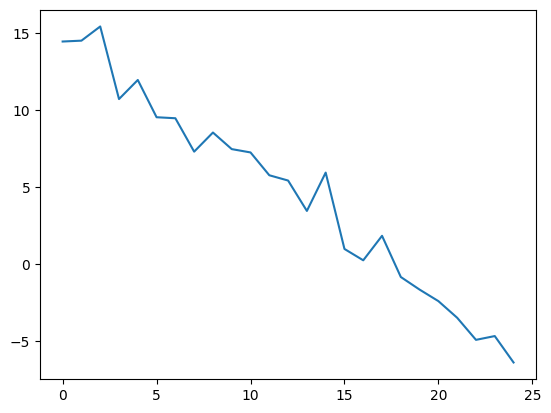

In [546]:
np.random.seed(230509)

n_obs = 25  # Distance to pass the user
intial_true_distance = 15
end_true_distance = -5
true_distances = np.linspace(intial_true_distance, end_true_distance, n_obs)  # Create array of true distances for each timestep
observed_distances = [np.random.normal(true_distances[i], 1) for i in range(n_obs)]  # sample from normal with mean true_distance and std 1
time_to_cross = 5

pdatas = []
idatas = []
chains = 2
draws = 1000
cores = 10

plt.plot(observed_distances)


# Setup Model

We predict the noise in the distance (as the distance keeps changing) and the speed (which is constant) .

The speed is inferred by a normal distribution that is updated using Bayes theorem with PyMC based on the observed speeds. 

$$ p(\theta | v) = \frac{p(\theta) p(v | \theta)}{\int{p(\theta) p(v | \theta)}} \propto p(\theta) p(v | \theta) $$

Where $\theta$ is the paramaters of the speed ($v$) distribution ($\mu_v$ and $\sigma_v$ ) and $v$ is the observed speeds.

The distance is inferred by the addition of the current distance observation plus the modelled noise which is based on the difference between the predicted current location and the observed current location.
The predicted current location is given by the previous location minus the inferred speed. Given the speed is constant we use the most up to date speed inferrance. 

$$ {\eta}_d = d_{o, t} - d_{p, t} $$
$$ d_{p, t} = d_{o, t-1} - \mu_v $$
$$ {\eta}_d = d_{o, t} - (d_{o, t-1} - \mu_v) $$

$$ p(\theta | {\eta}_d) = \frac{p(\theta) p({\eta}_d | \theta)}{\int{p(\theta) p({\eta}_d | \theta)}} \propto p(\theta) p({\eta}_d | \theta) $$

Where ${\eta}_d$ is the noise in $d$, $d_{o, t}$ is the distance observation at time $t$, $d_{p, t}$ is the predicted distance at $t$, and $\mu_v$ is the mean predicted speed, and $\theta$ is the paramaters $\mu_\eta$ and $\sigma_\eta$ of the distance noise (${\eta}_d$) distribution.   


The probability of safe crossing is then given by the probability of the vehicle being at less than 5 within the time to cross the road (which is 5 timesteps)

$$ p(safe) = (d_{o,t} + \eta_d)-(\mu_d \cdot t_{cross}) > t_{cross} $$

Where $p(safe)$ is the probability of crossing safely, and $t_{cross}$ is the time it takes for the user to cross the road, all other symbols are as before.

The model needs to have 2 observations, the current and the previous. So the model defined here uses the first two timesteps. 


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 10 jobs)
NUTS: [noise_sigma, speed_sigma, speed_mean, x_0_sigma, x_0_mean]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 8 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


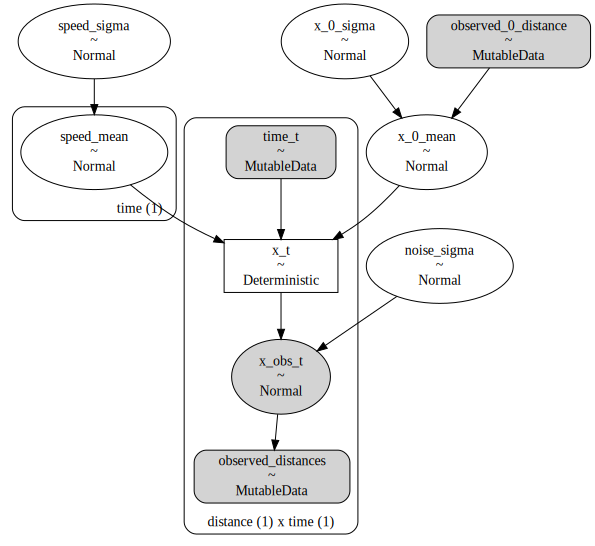

In [547]:
import pytensor

with pm.Model() as car_model:
    # Noise in the distance
    noise_sigma = pm.Normal('noise_sigma', 2, 5)

    # Data for the timesteps
    time_t = pm.MutableData('time_t', [[0]], dims=('distance', 'time'))


    # Infering speed
    speed_sigma = pm.Normal('speed_sigma', 1, 5)
    speed_mean = pm.Normal('speed_mean', 1, speed_sigma, dims='time') # Needs to have the same dims as time to get an inference for each timestep

    # Modelling the distances
    observed_distances_data = pm.MutableData('observed_distances', [observed_distances[:1]], dims=('distance', 'time'))
    observed_0_distance = pm.MutableData('observed_0_distance', observed_distances[0])

    distance_at_t0_sigma = pm.Normal('x_0_sigma', 2, 2)
    distance_at_t0_mean = pm.Normal('x_0_mean', observed_0_distance, distance_at_t0_sigma) # set the observed data to only the current timestep
    
    distance_at_t = pm.Deterministic('x_t', distance_at_t0_mean - (time_t * speed_mean), dims=('distance', 'time'))
    distance_at_t_mean = pm.Normal('x_obs_t', distance_at_t, noise_sigma, observed=observed_distances_data, dims=('distance', 'time'))

    idata = pm.sample(chains=chains, draws=draws, cores=cores)    
    idatas.append(idata)
    pdata = pm.sample_posterior_predictive(idata)
    pdatas.append(pdata)

pm.model_to_graphviz(car_model)

# Run Model

To run the model all the speed observations are put into the model for the speed prediction, only the current and previous distances are put into the model as previous distances are irrelevant for current distance prediction. All the previous noise models are added to the model as the model needs a memory of the previous noise values, and the new noise is added to the array of noises.

This is looped over from the start distance until the vehicle has passed the user

In [549]:
start = dt.now()
for i in range(1, n_obs):
  print(f'Running {i} -------------------------------------- at time {dt.now() - start}')
  with car_model:
    pm.set_data({'time_t': np.array([range(i+1)])-i})
    pm.set_data({'observed_distances': [observed_distances[:i+1]]})
    pm.set_data({'observed_0_distance': observed_distances[i]})
    idata = pm.sample(chains=chains, draws=draws, cores=cores)
    idatas.append(idata)
    pdata = pm.sample_posterior_predictive(idata)
    pdatas.append(pdata)
    print(f'times: {np.array([range(i+1)])-i}, distances: {[observed_distances[:i+1]]}, observed_0_distance: {observed_distances[i]}')

# Save data for long runs
# file_path = '/home/jonathan/Documents/Prob/samples_230411/'
# with open(file_path + f'idatas.pickle', 'wb') as fp:
#     pickle.dump(idatas, fp)

# with open(file_path + f'pdatas.pickle', 'wb') as fp:
#     pickle.dump(pdatas, fp)

Running 1 -------------------------------------- at time 0:00:00.000166


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 10 jobs)
NUTS: [noise_sigma, speed_sigma, speed_mean, x_0_sigma, x_0_mean]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 14 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


times: [[-1  0]], distances: [[14.43686543616061, 14.492609061313214]], observed_0_distance: 14.492609061313214
Running 2 -------------------------------------- at time 0:00:18.580423


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 10 jobs)
NUTS: [noise_sigma, speed_sigma, speed_mean, x_0_sigma, x_0_mean]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 17 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


times: [[-2 -1  0]], distances: [[14.43686543616061, 14.492609061313214, 15.413587446449073]], observed_0_distance: 15.413587446449073
Running 3 -------------------------------------- at time 0:00:38.423342


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 10 jobs)
NUTS: [noise_sigma, speed_sigma, speed_mean, x_0_sigma, x_0_mean]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 16 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


times: [[-3 -2 -1  0]], distances: [[14.43686543616061, 14.492609061313214, 15.413587446449073, 10.700522222150916]], observed_0_distance: 10.700522222150916
Running 4 -------------------------------------- at time 0:00:57.860198


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 10 jobs)
NUTS: [noise_sigma, speed_sigma, speed_mean, x_0_sigma, x_0_mean]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 19 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


times: [[-4 -3 -2 -1  0]], distances: [[14.43686543616061, 14.492609061313214, 15.413587446449073, 10.700522222150916, 11.939220915379368]], observed_0_distance: 11.939220915379368
Running 5 -------------------------------------- at time 0:01:20.686274


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 10 jobs)
NUTS: [noise_sigma, speed_sigma, speed_mean, x_0_sigma, x_0_mean]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 23 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


times: [[-5 -4 -3 -2 -1  0]], distances: [[14.43686543616061, 14.492609061313214, 15.413587446449073, 10.700522222150916, 11.939220915379368, 9.51970796624551]], observed_0_distance: 9.51970796624551
Running 6 -------------------------------------- at time 0:01:46.705197


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 10 jobs)
NUTS: [noise_sigma, speed_sigma, speed_mean, x_0_sigma, x_0_mean]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 13 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


times: [[-6 -5 -4 -3 -2 -1  0]], distances: [[14.43686543616061, 14.492609061313214, 15.413587446449073, 10.700522222150916, 11.939220915379368, 9.51970796624551, 9.453938501437033]], observed_0_distance: 9.453938501437033
Running 7 -------------------------------------- at time 0:02:02.396592


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 10 jobs)
NUTS: [noise_sigma, speed_sigma, speed_mean, x_0_sigma, x_0_mean]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 13 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


times: [[-7 -6 -5 -4 -3 -2 -1  0]], distances: [[14.43686543616061, 14.492609061313214, 15.413587446449073, 10.700522222150916, 11.939220915379368, 9.51970796624551, 9.453938501437033, 7.284530514967309]], observed_0_distance: 7.284530514967309
Running 8 -------------------------------------- at time 0:02:20.040827


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 10 jobs)
NUTS: [noise_sigma, speed_sigma, speed_mean, x_0_sigma, x_0_mean]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 9 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


times: [[-8 -7 -6 -5 -4 -3 -2 -1  0]], distances: [[14.43686543616061, 14.492609061313214, 15.413587446449073, 10.700522222150916, 11.939220915379368, 9.51970796624551, 9.453938501437033, 7.284530514967309, 8.52656896436379]], observed_0_distance: 8.52656896436379
Running 9 -------------------------------------- at time 0:02:32.144422


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 10 jobs)
NUTS: [noise_sigma, speed_sigma, speed_mean, x_0_sigma, x_0_mean]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 12 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


times: [[-9 -8 -7 -6 -5 -4 -3 -2 -1  0]], distances: [[14.43686543616061, 14.492609061313214, 15.413587446449073, 10.700522222150916, 11.939220915379368, 9.51970796624551, 9.453938501437033, 7.284530514967309, 8.52656896436379, 7.450090554765575]], observed_0_distance: 7.450090554765575
Running 10 -------------------------------------- at time 0:02:46.968782


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 10 jobs)
NUTS: [noise_sigma, speed_sigma, speed_mean, x_0_sigma, x_0_mean]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 12 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


times: [[-10  -9  -8  -7  -6  -5  -4  -3  -2  -1   0]], distances: [[14.43686543616061, 14.492609061313214, 15.413587446449073, 10.700522222150916, 11.939220915379368, 9.51970796624551, 9.453938501437033, 7.284530514967309, 8.52656896436379, 7.450090554765575, 7.233575711860135]], observed_0_distance: 7.233575711860135
Running 11 -------------------------------------- at time 0:03:03.025688


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 10 jobs)
NUTS: [noise_sigma, speed_sigma, speed_mean, x_0_sigma, x_0_mean]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 13 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


times: [[-11 -10  -9  -8  -7  -6  -5  -4  -3  -2  -1   0]], distances: [[14.43686543616061, 14.492609061313214, 15.413587446449073, 10.700522222150916, 11.939220915379368, 9.51970796624551, 9.453938501437033, 7.284530514967309, 8.52656896436379, 7.450090554765575, 7.233575711860135, 5.751683184540208]], observed_0_distance: 5.751683184540208
Running 12 -------------------------------------- at time 0:03:19.122731


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 10 jobs)
NUTS: [noise_sigma, speed_sigma, speed_mean, x_0_sigma, x_0_mean]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 10 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


times: [[-12 -11 -10  -9  -8  -7  -6  -5  -4  -3  -2  -1   0]], distances: [[14.43686543616061, 14.492609061313214, 15.413587446449073, 10.700522222150916, 11.939220915379368, 9.51970796624551, 9.453938501437033, 7.284530514967309, 8.52656896436379, 7.450090554765575, 7.233575711860135, 5.751683184540208, 5.408442592775835]], observed_0_distance: 5.408442592775835
Running 13 -------------------------------------- at time 0:03:32.721471


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 10 jobs)
NUTS: [noise_sigma, speed_sigma, speed_mean, x_0_sigma, x_0_mean]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 13 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


times: [[-13 -12 -11 -10  -9  -8  -7  -6  -5  -4  -3  -2  -1   0]], distances: [[14.43686543616061, 14.492609061313214, 15.413587446449073, 10.700522222150916, 11.939220915379368, 9.51970796624551, 9.453938501437033, 7.284530514967309, 8.52656896436379, 7.450090554765575, 7.233575711860135, 5.751683184540208, 5.408442592775835, 3.435237240511279]], observed_0_distance: 3.435237240511279
Running 14 -------------------------------------- at time 0:03:50.038213


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 10 jobs)
NUTS: [noise_sigma, speed_sigma, speed_mean, x_0_sigma, x_0_mean]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 9 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


times: [[-14 -13 -12 -11 -10  -9  -8  -7  -6  -5  -4  -3  -2  -1   0]], distances: [[14.43686543616061, 14.492609061313214, 15.413587446449073, 10.700522222150916, 11.939220915379368, 9.51970796624551, 9.453938501437033, 7.284530514967309, 8.52656896436379, 7.450090554765575, 7.233575711860135, 5.751683184540208, 5.408442592775835, 3.435237240511279, 5.924035736238462]], observed_0_distance: 5.924035736238462
Running 15 -------------------------------------- at time 0:04:02.325642


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 10 jobs)
NUTS: [noise_sigma, speed_sigma, speed_mean, x_0_sigma, x_0_mean]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 17 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


times: [[-15 -14 -13 -12 -11 -10  -9  -8  -7  -6  -5  -4  -3  -2  -1   0]], distances: [[14.43686543616061, 14.492609061313214, 15.413587446449073, 10.700522222150916, 11.939220915379368, 9.51970796624551, 9.453938501437033, 7.284530514967309, 8.52656896436379, 7.450090554765575, 7.233575711860135, 5.751683184540208, 5.408442592775835, 3.435237240511279, 5.924035736238462, 0.966073666803114]], observed_0_distance: 0.966073666803114
Running 16 -------------------------------------- at time 0:04:22.705087


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 10 jobs)
NUTS: [noise_sigma, speed_sigma, speed_mean, x_0_sigma, x_0_mean]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 24 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


times: [[-16 -15 -14 -13 -12 -11 -10  -9  -8  -7  -6  -5  -4  -3  -2  -1   0]], distances: [[14.43686543616061, 14.492609061313214, 15.413587446449073, 10.700522222150916, 11.939220915379368, 9.51970796624551, 9.453938501437033, 7.284530514967309, 8.52656896436379, 7.450090554765575, 7.233575711860135, 5.751683184540208, 5.408442592775835, 3.435237240511279, 5.924035736238462, 0.966073666803114, 0.22880526202252782]], observed_0_distance: 0.22880526202252782
Running 17 -------------------------------------- at time 0:04:50.809332


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 10 jobs)
NUTS: [noise_sigma, speed_sigma, speed_mean, x_0_sigma, x_0_mean]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 11 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


times: [[-17 -16 -15 -14 -13 -12 -11 -10  -9  -8  -7  -6  -5  -4  -3  -2  -1   0]], distances: [[14.43686543616061, 14.492609061313214, 15.413587446449073, 10.700522222150916, 11.939220915379368, 9.51970796624551, 9.453938501437033, 7.284530514967309, 8.52656896436379, 7.450090554765575, 7.233575711860135, 5.751683184540208, 5.408442592775835, 3.435237240511279, 5.924035736238462, 0.966073666803114, 0.22880526202252782, 1.8193485474587718]], observed_0_distance: 1.8193485474587718
Running 18 -------------------------------------- at time 0:05:04.752170


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 10 jobs)
NUTS: [noise_sigma, speed_sigma, speed_mean, x_0_sigma, x_0_mean]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 11 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


times: [[-18 -17 -16 -15 -14 -13 -12 -11 -10  -9  -8  -7  -6  -5  -4  -3  -2  -1
    0]], distances: [[14.43686543616061, 14.492609061313214, 15.413587446449073, 10.700522222150916, 11.939220915379368, 9.51970796624551, 9.453938501437033, 7.284530514967309, 8.52656896436379, 7.450090554765575, 7.233575711860135, 5.751683184540208, 5.408442592775835, 3.435237240511279, 5.924035736238462, 0.966073666803114, 0.22880526202252782, 1.8193485474587718, -0.856141296086911]], observed_0_distance: -0.856141296086911
Running 19 -------------------------------------- at time 0:05:18.760732


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 10 jobs)
NUTS: [noise_sigma, speed_sigma, speed_mean, x_0_sigma, x_0_mean]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 11 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


times: [[-19 -18 -17 -16 -15 -14 -13 -12 -11 -10  -9  -8  -7  -6  -5  -4  -3  -2
   -1   0]], distances: [[14.43686543616061, 14.492609061313214, 15.413587446449073, 10.700522222150916, 11.939220915379368, 9.51970796624551, 9.453938501437033, 7.284530514967309, 8.52656896436379, 7.450090554765575, 7.233575711860135, 5.751683184540208, 5.408442592775835, 3.435237240511279, 5.924035736238462, 0.966073666803114, 0.22880526202252782, 1.8193485474587718, -0.856141296086911, -1.674128726579174]], observed_0_distance: -1.674128726579174
Running 20 -------------------------------------- at time 0:05:33.489544


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 10 jobs)
NUTS: [noise_sigma, speed_sigma, speed_mean, x_0_sigma, x_0_mean]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 10 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


times: [[-20 -19 -18 -17 -16 -15 -14 -13 -12 -11 -10  -9  -8  -7  -6  -5  -4  -3
   -2  -1   0]], distances: [[14.43686543616061, 14.492609061313214, 15.413587446449073, 10.700522222150916, 11.939220915379368, 9.51970796624551, 9.453938501437033, 7.284530514967309, 8.52656896436379, 7.450090554765575, 7.233575711860135, 5.751683184540208, 5.408442592775835, 3.435237240511279, 5.924035736238462, 0.966073666803114, 0.22880526202252782, 1.8193485474587718, -0.856141296086911, -1.674128726579174, -2.422659408994522]], observed_0_distance: -2.422659408994522
Running 21 -------------------------------------- at time 0:05:47.049655


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 10 jobs)
NUTS: [noise_sigma, speed_sigma, speed_mean, x_0_sigma, x_0_mean]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 30 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


times: [[-21 -20 -19 -18 -17 -16 -15 -14 -13 -12 -11 -10  -9  -8  -7  -6  -5  -4
   -3  -2  -1   0]], distances: [[14.43686543616061, 14.492609061313214, 15.413587446449073, 10.700522222150916, 11.939220915379368, 9.51970796624551, 9.453938501437033, 7.284530514967309, 8.52656896436379, 7.450090554765575, 7.233575711860135, 5.751683184540208, 5.408442592775835, 3.435237240511279, 5.924035736238462, 0.966073666803114, 0.22880526202252782, 1.8193485474587718, -0.856141296086911, -1.674128726579174, -2.422659408994522, -3.5041318856028814]], observed_0_distance: -3.5041318856028814
Running 22 -------------------------------------- at time 0:06:20.054373


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 10 jobs)
NUTS: [noise_sigma, speed_sigma, speed_mean, x_0_sigma, x_0_mean]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 29 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


times: [[-22 -21 -20 -19 -18 -17 -16 -15 -14 -13 -12 -11 -10  -9  -8  -7  -6  -5
   -4  -3  -2  -1   0]], distances: [[14.43686543616061, 14.492609061313214, 15.413587446449073, 10.700522222150916, 11.939220915379368, 9.51970796624551, 9.453938501437033, 7.284530514967309, 8.52656896436379, 7.450090554765575, 7.233575711860135, 5.751683184540208, 5.408442592775835, 3.435237240511279, 5.924035736238462, 0.966073666803114, 0.22880526202252782, 1.8193485474587718, -0.856141296086911, -1.674128726579174, -2.422659408994522, -3.5041318856028814, -4.9372641723618145]], observed_0_distance: -4.9372641723618145
Running 23 -------------------------------------- at time 0:06:53.122115


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 10 jobs)
NUTS: [noise_sigma, speed_sigma, speed_mean, x_0_sigma, x_0_mean]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 10 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


times: [[-23 -22 -21 -20 -19 -18 -17 -16 -15 -14 -13 -12 -11 -10  -9  -8  -7  -6
   -5  -4  -3  -2  -1   0]], distances: [[14.43686543616061, 14.492609061313214, 15.413587446449073, 10.700522222150916, 11.939220915379368, 9.51970796624551, 9.453938501437033, 7.284530514967309, 8.52656896436379, 7.450090554765575, 7.233575711860135, 5.751683184540208, 5.408442592775835, 3.435237240511279, 5.924035736238462, 0.966073666803114, 0.22880526202252782, 1.8193485474587718, -0.856141296086911, -1.674128726579174, -2.422659408994522, -3.5041318856028814, -4.9372641723618145, -4.690728077559365]], observed_0_distance: -4.690728077559365
Running 24 -------------------------------------- at time 0:07:05.959578


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 10 jobs)
NUTS: [noise_sigma, speed_sigma, speed_mean, x_0_sigma, x_0_mean]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 14 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


times: [[-24 -23 -22 -21 -20 -19 -18 -17 -16 -15 -14 -13 -12 -11 -10  -9  -8  -7
   -6  -5  -4  -3  -2  -1   0]], distances: [[14.43686543616061, 14.492609061313214, 15.413587446449073, 10.700522222150916, 11.939220915379368, 9.51970796624551, 9.453938501437033, 7.284530514967309, 8.52656896436379, 7.450090554765575, 7.233575711860135, 5.751683184540208, 5.408442592775835, 3.435237240511279, 5.924035736238462, 0.966073666803114, 0.22880526202252782, 1.8193485474587718, -0.856141296086911, -1.674128726579174, -2.422659408994522, -3.5041318856028814, -4.9372641723618145, -4.690728077559365, -6.4063610940240885]], observed_0_distance: -6.4063610940240885


# Plotting results

The plots below are: 
- predicted and actual distances for each time step 
- noise prediction for each time step
- speed prediction for each time step
- probability of crossing safely at each timestep

In [550]:
idata

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data
	> constant_data

In [551]:
def get_confidence_intervals(data):
    indicies = ['2.5','25','50','75','97.5']
    CI = {}
    _CI = np.quantile(data, [0.025,0.25,0.5,0.75,0.975], axis=0)

    for i, index in enumerate(indicies):
        CI[index] = _CI[i]
    
    return CI

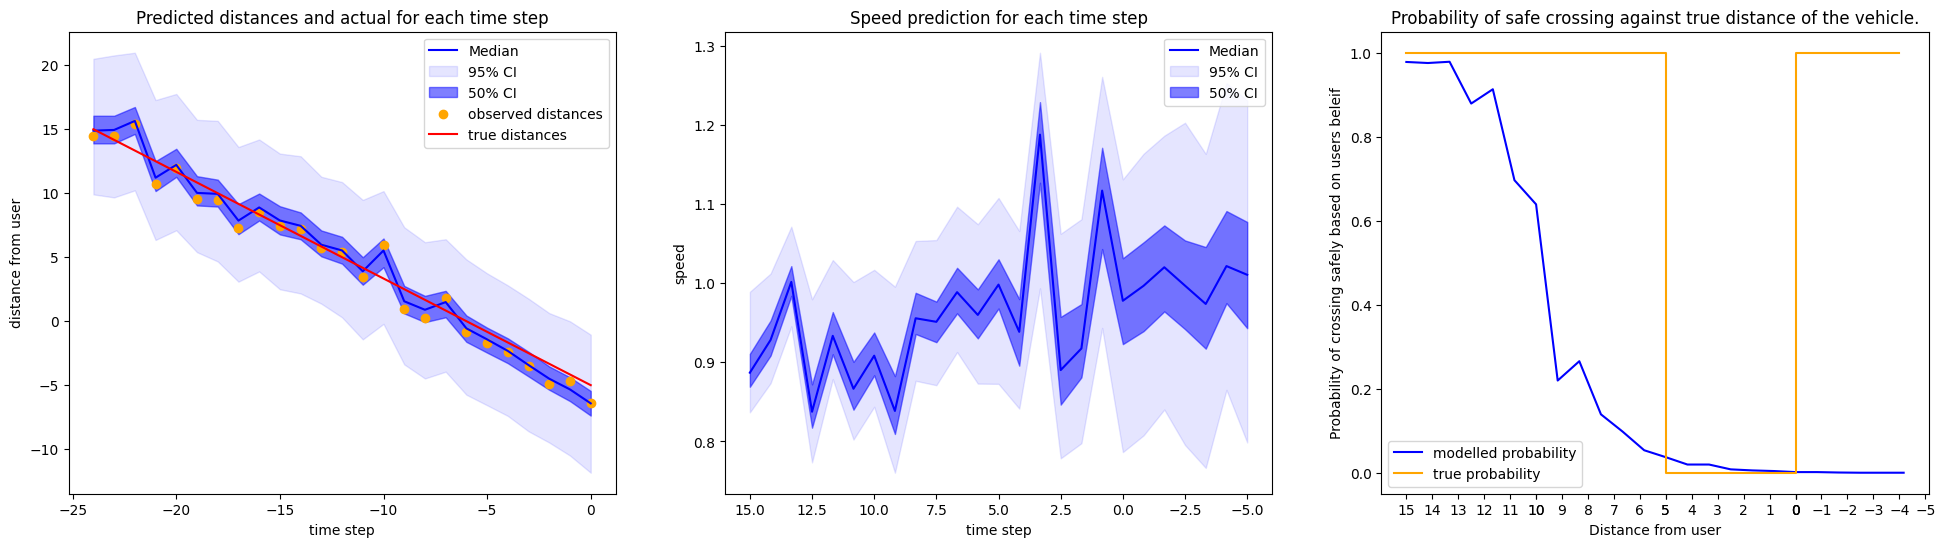

In [558]:
t_obs = len(idatas)-1
fig, axes = plt.subplots(1, 3, figsize=(8*3, 6))
pdata = pdatas[t_obs]
idata = idatas[t_obs]

# Predicted and actual distances for each time step 
ax = axes[0]
## Plot median and CI
t = np.arange(t_obs+1)-t_obs
predicted_distances = np.array(pdata.posterior_predictive.x_obs_t).reshape([chains*draws, t_obs+1])
confidence_intervals = get_confidence_intervals(predicted_distances)
ax.plot(t, confidence_intervals['50'], color='blue', label='Median')
ax.fill_between(t, confidence_intervals['2.5'], confidence_intervals['97.5'], color='blue', alpha=0.1, label='95% CI')
ax.fill_between(t, confidence_intervals['25'], confidence_intervals['75'], color='blue', alpha=0.5, label='50% CI')
## Plot actual and observed 
ax.scatter(x=t, y=observed_distances, label='observed distances', color='orange')
ax.plot(t, true_distances, label='true distances', color='red')
## Configure title, axes labels, and legend 
# ax.invert_xaxis()
ax.set_title('Predicted distances and actual for each time step')
ax.set_xlabel('time step')
ax.set_ylabel('distance from user')
ax.legend()

# ax.plot(true_distances, [5 for i in true_distances], color='k')
# ax.plot(true_distances, [0 for i in true_distances], color='k')
# ax.plot([5 for i in true_distances], true_distances, color='k')
# ax.plot([0 for i in true_distances], true_distances, color='k')

# Speed prediction for each time step
ax = axes[1]
speeds = np.array(idata.posterior.speed_mean).reshape([chains*draws, t_obs+1])
confidence_intervals = get_confidence_intervals(speeds)
ax.plot(true_distances[:t_obs+1], confidence_intervals['50'], color='blue', label='Median')
ax.fill_between(true_distances[:t_obs+1], confidence_intervals['2.5'], confidence_intervals['97.5'], color='blue', alpha=0.1, label='95% CI')
ax.fill_between(true_distances[:t_obs+1], confidence_intervals['25'], confidence_intervals['75'], color='blue', alpha=0.5, label='50% CI')
## Configure title, axes labels, and legend 
ax.set_title('Speed prediction for each time step')
ax.set_xlabel('time step')
ax.set_ylabel('speed')
ax.legend()
ax.invert_xaxis()



# the probability of crossing safely at each timestep
p_data = (predicted_distances - 5*speeds)
safe_percents = []
true_prob = []
d = []

for i in range(t_obs):
    d.append(int(true_distances[i]))
    safe_approaching = (p_data.T[i] > time_to_cross)
    safe_passed = (p_data.T[i] < 0)
    safe = np.count_nonzero(np.logical_or(safe_approaching, safe_passed))/len(p_data.T[i])
    safe_approach_only = np.count_nonzero(safe_approaching)/len(p_data.T[i])
    # safe_percents.append(safe)
    safe_percents.append(safe_approach_only)
    if true_distances[i] > time_to_cross or true_distances[i] < 0:
        true_prob.append(1)
    else:
        true_prob.append(0)



ax = axes[2]
ax.plot(true_distances[:t_obs], safe_percents, label='modelled probability', color='blue')
ax.plot(d, true_prob, label='true probability', color='orange')

ax.invert_xaxis()
ax.set_title("Probability of safe crossing against true distance of the vehicle.")
ax.set_xlabel('Distance from user')
ax.set_ylabel('Probability of crossing safely based on users beleif')
ax.set_xticks([int(i) for i in true_distances])
ax.legend()

In [553]:
np.array(pdata.posterior_predictive.x_obs_t).shape

(2, 1000, 1, 25)

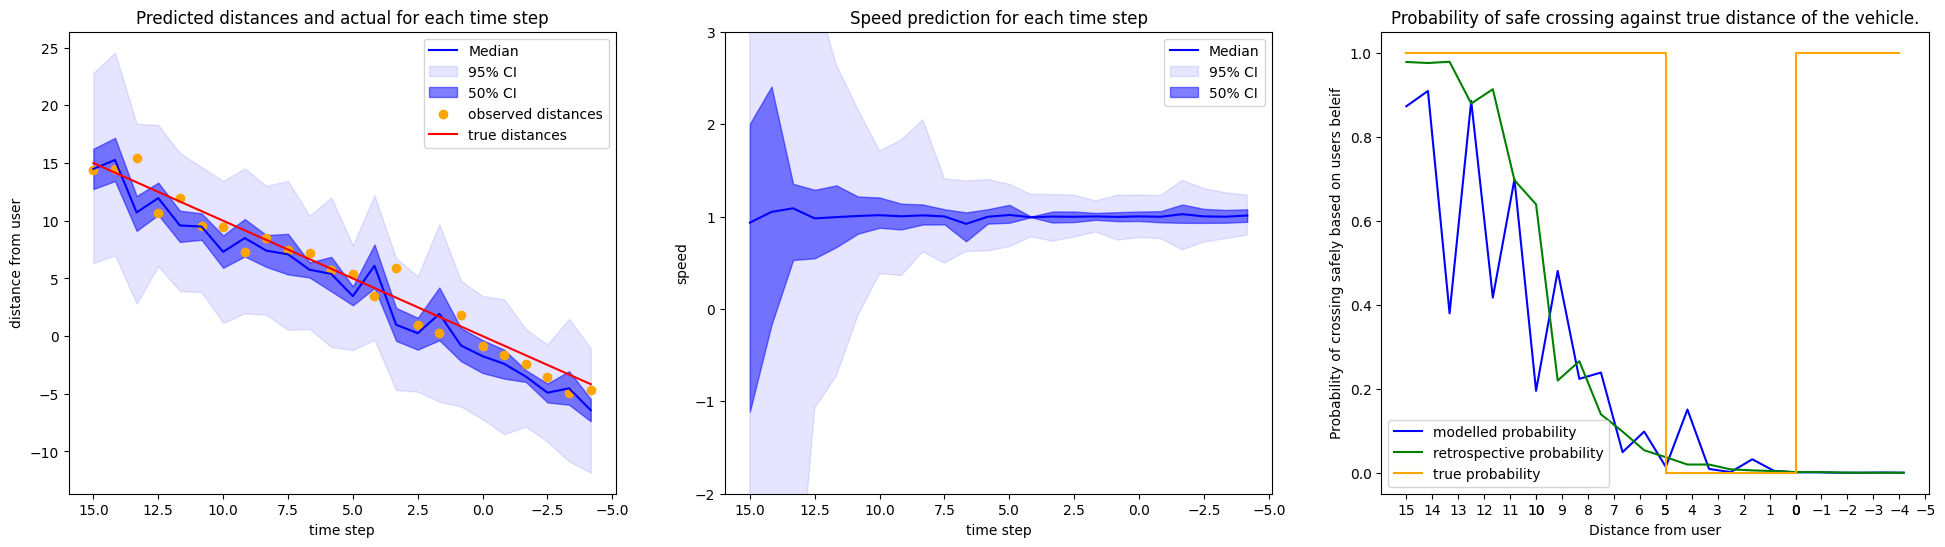

In [560]:
confidence_intervals_d = {}
confidence_intervals_v = {}
CI_indicies = ['2.5','25','50','75','97.5']
for index in CI_indicies:
    confidence_intervals_d[index] = []
    confidence_intervals_v[index] = []
safe_percents = []

for t_obs in range(1,n_obs):
    pdata = pdatas[t_obs]
    idata = idatas[t_obs]
    predicted_distances_t = np.array(pdata.posterior_predictive.x_obs_t).reshape([chains*draws, t_obs+1])
    speeds_t = np.array(idata.posterior.speed_mean).reshape([chains*draws, t_obs+1])

    confidence_intervals_d_t = get_confidence_intervals(predicted_distances_t)
    confidence_intervals_v_t = get_confidence_intervals(speeds_t)
    for index in CI_indicies:
        confidence_intervals_d[index].append(confidence_intervals_d_t[index][-1])
        confidence_intervals_v[index].append(confidence_intervals_v_t[index][-1])

    p_data = (predicted_distances_t - 5*speeds_t)
    safe_percents_t = []
    for i in range(t_obs):
        safe_approaching = (p_data.T[i] > time_to_cross)
        safe_passed = (p_data.T[i] < 0)
        safe = np.count_nonzero(np.logical_or(safe_approaching, safe_passed))/len(p_data.T[i])
        safe_approach_only = np.count_nonzero(safe_approaching)/len(p_data.T[i])
        safe_percents_t.append(safe_approach_only)
    safe_percents.append(safe_percents_t[-1])

fig, axes = plt.subplots(1, 3, figsize=(8*3, 6))

# Predicted and actual distances for each time step 
ax = axes[0]
## Plot median and CI
t_obs = t_obs
ax.plot(true_distances[:t_obs], confidence_intervals_d['50'], color='blue', label='Median')
ax.fill_between(true_distances[:t_obs], confidence_intervals_d['2.5'], confidence_intervals_d['97.5'], color='blue', alpha=0.1, label='95% CI')
ax.fill_between(true_distances[:t_obs], confidence_intervals_d['25'], confidence_intervals_d['75'], color='blue', alpha=0.5, label='50% CI')
## Plot actual and observed 
ax.scatter(x=true_distances[:t_obs], y=observed_distances[:t_obs], label='observed distances', color='orange')
ax.plot(true_distances[:t_obs], true_distances[:t_obs], label='true distances', color='red')
## Configure title, axes labels, and legend 
ax.invert_xaxis()
ax.set_title('Predicted distances and actual for each time step')
ax.set_xlabel('time step')
ax.set_ylabel('distance from user')
ax.legend()


# Speed prediction for each time step
ax = axes[1]

ax.plot(true_distances[:t_obs], confidence_intervals_v['50'], color='blue', label='Median')
ax.fill_between(true_distances[:t_obs], confidence_intervals_v['2.5'], confidence_intervals_v['97.5'], color='blue', alpha=0.1, label='95% CI')
ax.fill_between(true_distances[:t_obs], confidence_intervals_v['25'], confidence_intervals_v['75'], color='blue', alpha=0.5, label='50% CI')
## Configure title, axes labels, and legend 
ax.set_title('Speed prediction for each time step')
ax.set_xlabel('time step')
ax.set_ylabel('speed')
ax.legend()
ax.invert_xaxis()
ax.set_ylim(-2,3)


# the probability of crossing safely at each timestep
ax = axes[2]

ax.plot(true_distances[:t_obs], safe_percents, label='modelled probability', color='blue')
ax.plot(true_distances[:t_obs], safe_percents_t, label='retrospective probability', color='green')
ax.plot(d, true_prob, label='true probability', color='orange')
## Configure title, axes labels, and legend 
ax.invert_xaxis()
ax.set_title("Probability of safe crossing against true distance of the vehicle.")
ax.set_xlabel('Distance from user')
ax.set_ylabel('Probability of crossing safely based on users beleif')
ax.set_xticks([int(i) for i in true_distances])
ax.legend()

In [555]:
pdatas[t_obs-1]

Inference data with groups:
	> posterior_predictive
	> observed_data
	> constant_data